# 量子コンピューティング I 第9回 FTQC編 第二回 スタビライザ符号とフォールトトレランス​

## 量子誤り訂正符号の閾値導出
量子誤り訂正符号(や符号族)の閾値は解析的に得ることが難しいことがほとんどです。そこで符号スケール(符号長や連接レベル)を変更した際に物理誤り率に対して論理誤り率がどのように振る舞うかをモンテカルロシミュレーションしてみましょう。今回はGoogleのシミュレータライブラリStimを用いて実際にシミュレーションを行ってみましょう。

In [1]:
!pip install stim~=1.14
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy

In [2]:
import stim
print(stim.__version__)

1.15.0


# 単純な回路を作ってみる
Stimでの回路は [`stim.Circuit`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit) classで扱われます。`stim.Circuit()`で空の回路を作成でき、`circuit.append(name_of_gate, list_of_targets)`でゲートなどを追加できます。

扱えるゲートは [Stim ゲートのリファレンス](https://github.com/quantumlib/Stim/blob/main/doc/gates.md) を参照のこと。

Bellペアを作る回路は以下のように作れます。面倒さはQiskitの回路と大差ないはずです。

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

回路の中身を表示するには以下のようにします。

In [4]:
circuit

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')

 [`circuit.diagram`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.diagram) だとより回路的に表示できます。

In [5]:
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

([SVG](https://en.wikipedia.org/wiki/SVG))画像としても出力可能である。

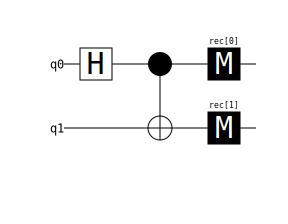

In [6]:
circuit.diagram('timeline-svg')

Anyways, let's stop looking at your circuit and start using it. You can sample from the circuit by using the [`circuit.compile_sampler()`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.compile_sampler) method を使うことでサンプリングしてみよう。

In [7]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[False False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [False False]]


1行につき2つの結果があり、各量子ビットの測定結果に対応している。
各行はショットに対応しており、Bell状態を測定しているので行内では結果は一致していることが確かめられる。

<!-- <a class="anchor" id="sample-detectors"></a>
# 4. Add detector annotations to a circuit, and sample them

Stim circuits can include error-correction annotations.
In particular, you can annotate that certain sets of measurements can be used to detect errors.
For example, in the circuit you created above, the two measurement results should always be equal.
You can tell Stim you care about that by adding a `DETECTOR` annotation to the circuit.

The `DETECTOR` annotation will take two targets: the two measurements whose parity you are asserting should be consistent from run to run. You point at the measurements by using the [`stim.target_rec`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.target_rec) method (short for "target measurement record"). The most recent measurement is `stim.target_rec(-1)` (also known as `rec[-1]` in Stim's circuit language), and the second most recent measurement is `stim.target_rec(-2)`: -->


<a class="anchor" id="sample-detectors"></a>.
# 回路に検出器`Detector`のアノテーションを追加し、サンプリングする

Stim回路は誤り訂正用の測定を含むことができます。
例えば、上で作成した回路では、2つの測定結果は常に等しくなければなりません。
回路に `DETECTOR` を追加することで、チェックしたいことを Stim に渡すことができます。

DETECTOR`は2つのターゲットを取ります。実行ごとにパリティが一貫していることを保証する2つの測定値です。[`stim.target_rec`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.target_rec) メソッド("target measurement record "の略)を使用して測定値を指定します。最も新しい測定値は `stim.target_rec(-1)` (Stim の回路言語では `rec[-1]` とも呼ばれる)、2番目に新しい測定値は `stim.target_rec(-2)` で呼ぶことができます。

In [8]:
# Indicate the two previous measurements are supposed to consistently agree.
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


A slightly subtle point about detectors is that they only assert that the parity of the measurements is *always the same under noiseless execution*.
A detector doesn't say whether the parity should be even or should be odd, only that it should always be the same.
You annotate that a pair of measurements is always different in the same way that you annotate that a pair of measurements is always the same; it's the *consistency* that's key.

Moving on, now that you've annotated the circuit with a detector, you can sample from the circuit's detectors instead of sampling from its measurements.
You do that by creating a detector sampler, using the [`compile_detector_sampler`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.compile_detector_sampler) method, and then calling [`sample`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.CompiledDetectorSampler.sample) on it.


検出器について注意すべきことは、検出器はノイズのない実行のもとで、測定値のパリティが常に同じであることを主張するだけだということです。検出器は、パリティが偶数であるべきか奇数であるべきかを言うのではなく、常に同じであるべきであることだけを示します。
測定値のペアが常に異なることを注釈するのは、測定値のペアが常に同じであることを注釈するのと同じです。

回路に検出器のアノテーションを付けたので、回路の測定値からサンプリングする代わりに、回路の検出器からサンプリングできます。
そのためには、[`compile_detector_sampler`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.compile_detector_sampler)メソッドを使用して検出器サンプラーを作成し、それに対して[`sample`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.CompiledDetectorSampler.sample)を呼び出します。

In [9]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


<!-- There are 5 rows in the results, because you took 5 shots.
There's one entry per row, because you put one detector in the circuit.

Notice how the results are always `False`.
This means the detector is never producing a detection event.
That's because there's no noise in the circuit; nothing to disturb the peace and quiet of a perfectly working machine.
Well... time to fix that!

Stim has a variety of error channels to pick from, like single qubit depolarization (`DEPOLARIZE1`) and phase damping (`Z_ERROR`), but in this context a good error to try is `X_ERROR`.
The `X_ERROR` noise channel probabilistically applies a bit flip (a Pauli X error) to each of its targets.
Note that each target is operated on independently.
They don't all flip together with the given probability, each one flips individually with the given probability.

You can recreate the circuit, with the noise inserted, by using Stim's domain specific language for circuits. While you're at it, throw in some `TICK` instructions to indicate the progression of time: -->

結果には5つの行があります。
1つの行に1つの項目があるのは、回路に1つの検出器を入れたからです。

結果が常に`False`であることに注意してください。
これは検出器が検出イベントを生成していないことを意味します。
これは回路内にノイズがないためで、完全に動作しているマシンの平穏と静寂を妨げるものは何もありません。
さて...誤りを入れてみましょう！

Stimには単一量子ビットの脱分極（`DEPOLARIZE1`）や位相減衰（`Z_ERROR`）のような様々なエラーチャンネルがありますが、`X_ERROR`を試してみましょう。
X_ERROR`ノイズ・チャンネルは確率的にビット・フリップ（パウリXエラー）を各ターゲットに適用するノイズ通信路です。
各ターゲットは独立して処理されることに注意してください。与えられた確率で一斉にフリップするのではなく、それぞれが与えられた確率で個別にフリップします。

Stimの回路用ドメイン固有言語を使えば、ノイズを挿入した回路を再現できます。ついでに、時間の経過を示す`TICK`命令も入れてみます：

In [10]:
circuit = stim.Circuit("""
    H 0
    TICK

    CX 0 1
    X_ERROR(0.2) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

`TICK`命令を入れたことで、新しい画像形式`timeslice-svg`を使用可能になります。QiksitのBarrier命令のようなものだと考えれば良いです。

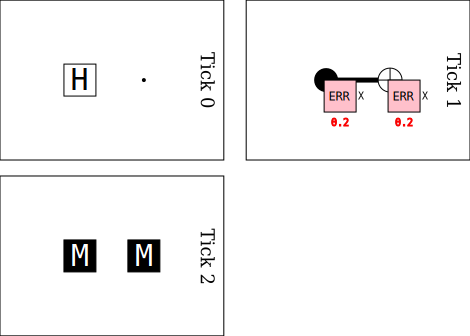

In [11]:
circuit.diagram('timeslice-svg')

ノイズを追加したことでサンプリングの結果がどう変わったかみてみましょう。

In [12]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]]


先ほどと違って毎回 `False`になりませんね。

The *detection fraction* of the circuit is how often detectors fire on average.
Given that an X error is being applied to each qubit with 20% probability, and the detector will fire when one of the qubits is hit (but not both), the detection fraction of the detectors in this circuit is $0.8 \cdot 0.2 \cdot 2 = 0.32$.

You can estimate the detection fraction by just taking a lot of shots, and dividing by the number of shots and the number of detectors:

回路の*検出率*とは、平均してどれくらいの頻度で検出器が動作するかということです。
それぞれの量子ビットに20%の確率でXの誤差がかかり、どちらか一方に当たると（両方には当たらない）検出器が作動すると考えると、この回路の検出器の検出率は$0.8 \cdot 0.2 \cdot 2 = 0.32$.となります。

この検出器の検出率は、たくさんShot数を回して、Shot数と検出器の数で割れば導出できます。

In [13]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.318812


<!-- As you can see, the sampled estimate ends up close to the expected value $0.32$. -->
見ての通り、サンプリングされた推定値は期待値$0.32$に近い値になっています。

<a class="anchor" id="make-qec-circuits"></a>
# 5. Generate example error correction circuits

Now it's time for you to work with a *real* error-correcting circuit.
Well... a classical error-correcting circuit:
the *repetition* code.

You could generate a repetition code circuit for yourself, but for the purposes of this tutorial it's easiest to use the example included with Stim.
You can do this by calling [`stim.Circuit.generated`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.generated) with an argument of `"repetition_code:memory"`.
(You can find out about other valid arguments in the method's doc string, or just by passing in a bad one and looking at the exception message that comes out.)

Stim takes a few different parameters when generating circuits.
You have to decide how many times the stabilizers of the code are measured by specifying `rounds`, you have to decide on the size of the code by specifying `distance`, and you can specify what kind of noise to include using a few optional parameters.

To start with, just set `before_round_data_depolarization=0.04` and `before_measure_flip_probability=0.01`. This will insert a `DEPOLARIZE1(0.04)` operation at the start of each round targeting every data qubit, and an `X_ERROR(0.01)` just before each measurement operation.
This is a "phenomenological noise model".

<a class="anchor" id="make-qec-circuits"></a>.
# 誤り訂正回路の例を生成する

さて、そろそろ*実際の*誤り訂正回路を使って作業する時間です。
古典的なエラー訂正回路です：*繰り返し*符号を試してみましょう。

自分で繰り返しコード回路を生成することもできますが、このチュートリアルでは、Stimに含まれているサンプルを使うのが一番簡単です。
そのためには、[`stim.Circuit.generated`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.generated) に `"repetition_code:memory"` という引数を指定して呼び出します。
(他の有効な引数については、メソッドのドキュメント文字列で知ることができますし、単に悪い引数を渡して、出てくる例外メッセージを見てください)。

Stimは回路を生成するときにいくつかの異なるパラメータを取ります。
`rounds`を指定してコードのスタビライザーを何回測定するかを決めたり、`distance`を指定して符号のサイズを決めたり、いくつかのオプションのパラメーターを使ってどんなノイズを含めるかを指定したりできます。

まず、`before_round_data_depolarization=0.04`と`before_measure_flip_probability=0.01`を設定する。これにより、各ラウンドの開始時にすべてのデータ量子ビットを対象とした `DEPOLARIZE1(0.04)` オペレーションが挿入され、各測定オペレーションの直前に `X_ERROR(0.01)` オペレーションが挿入されます。
これは "現象論的ノイズモデル "です。


stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    DEPOLARIZE1(0.04) 0 2 4 6 8 10 12 14 16
    CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
    TICK
    X_ERROR(0.01) 1 3 5 7 9 11 13 15
    MR 1 3 5 7 9 11 13 15
    DETECTOR(1, 0) rec[-8]
    DETECTOR(3, 0) rec[-7]
    DETECTOR(5, 0) rec[-6]
    DETECTOR(7, 0) rec[-5]
    DETECTOR(9, 0) rec[-4]
    DETECTOR(11, 0) rec[-3]
    DETECTOR(13, 0) rec[-2]
    DETECTOR(15, 0) rec[-1]
    REPEAT 24 {
        TICK
        DEPOLARIZE1(0.04) 0 2 4 6 8 10 12 14 16
        CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
        TICK
        X_ERROR(0.01) 1 3 5 7 9 11 13 15
        MR 1 3 5 7 9 11 13 15
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-8] rec[-16]
        DETECTOR(3, 0) rec[-7] rec[-15]
        DETECTOR(5, 0) rec[-6] rec[-14]
        DETECTOR(7, 0) rec[-5] rec[-13]
        DETECTOR(9, 0) rec[-4] r

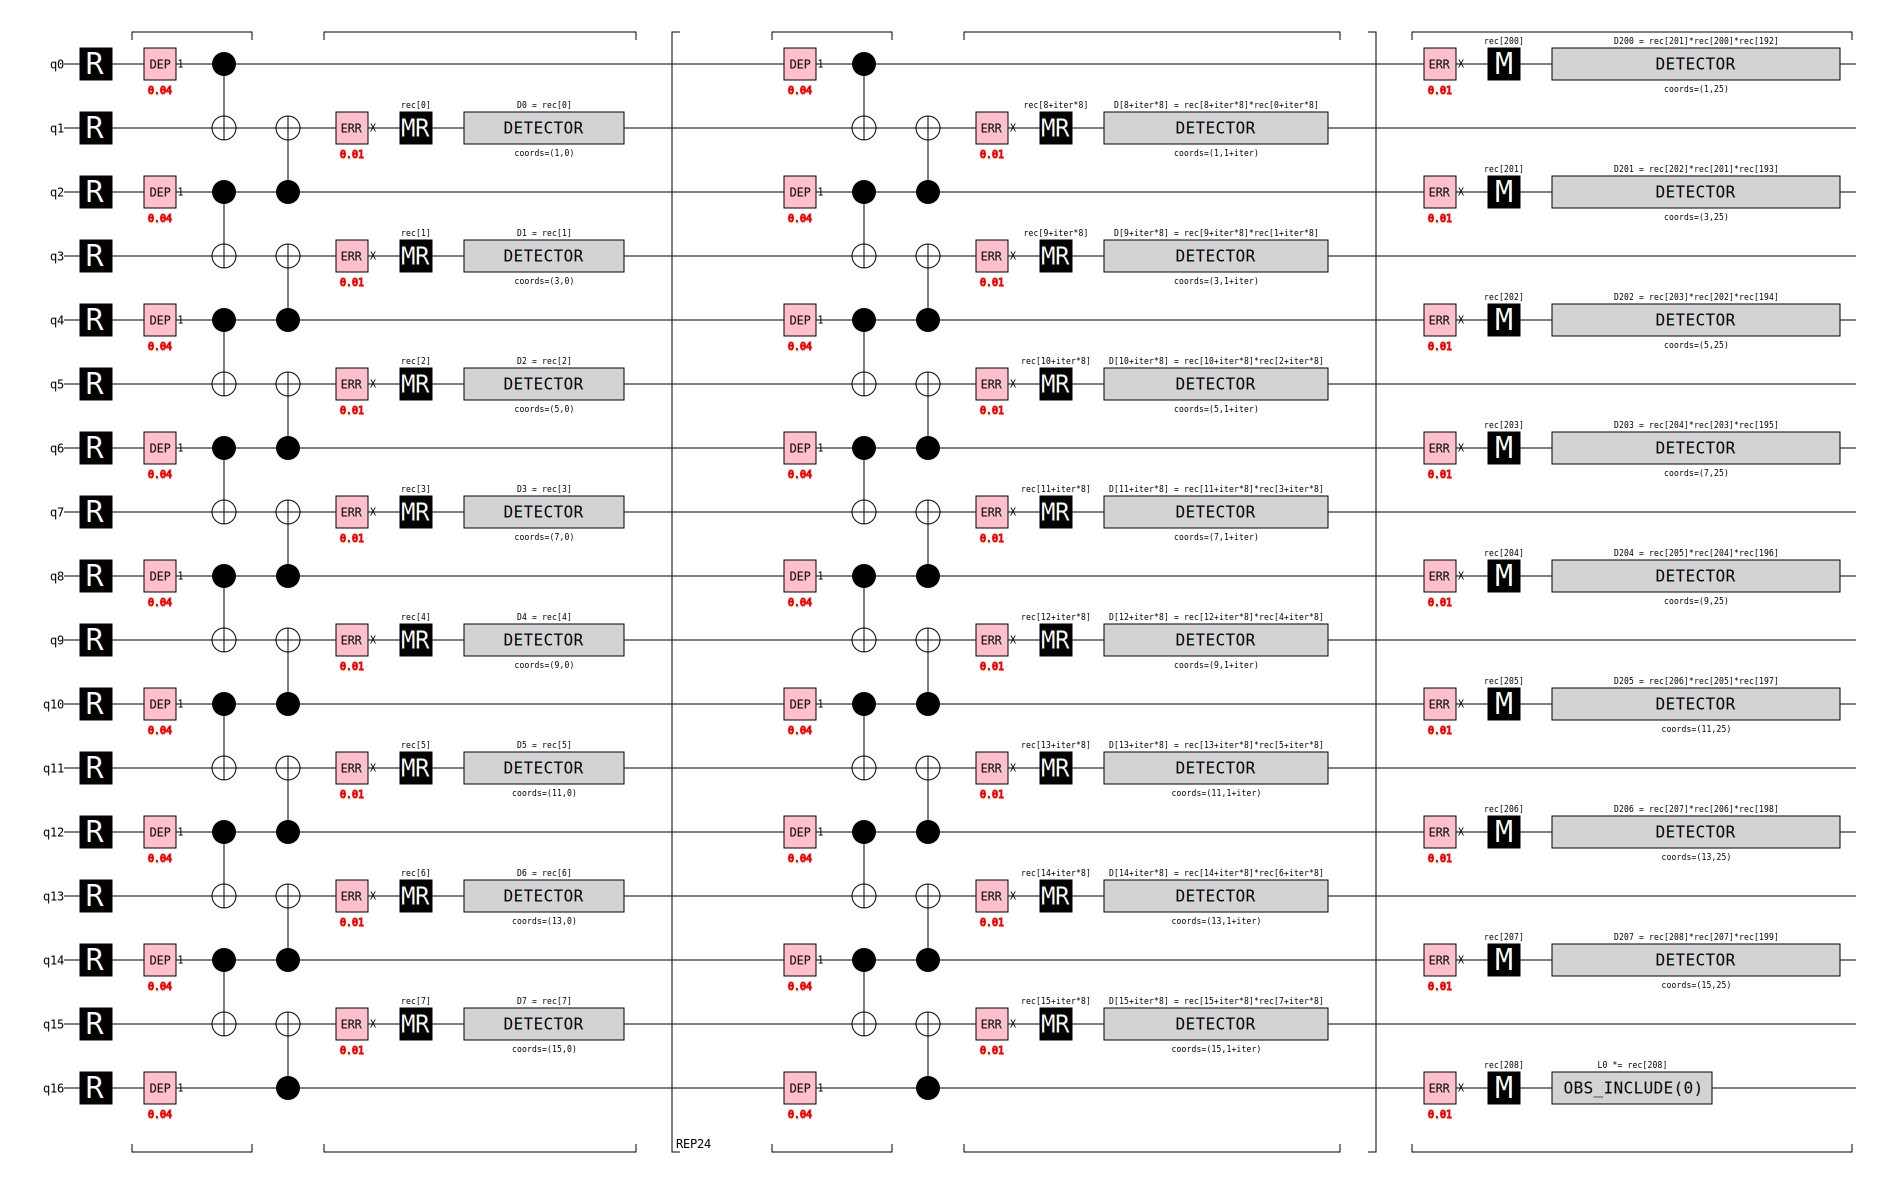

In [14]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=25,
    distance=9,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01)

print(repr(circuit))
circuit.diagram('timeline-svg')

## ノイズモデル
閾値計算で用いられる代表的なノイズモデルは以下になります。ノイズモデルや符号に応じて閾値は変化します。

① Depolarizing Noise（脱分極モデル）
各ビットにランダムなPauli誤り（X/Y/Z）が確率 p で独立に発生。対称で解析が容易、最も理想化されたモデル。

② Phenomenological Noise（現象論的モデル）
データ量子ビットとシンドローム測定に誤りが入るが、ゲートによる誤り伝播は考慮しない。トポロジカル符号（Surface, Toric）のしきい値評価に多用される。閾値は①に比して低下。

③ Circuit-level Noise（回路レベルモデル）
各ゲート・測定・初期化の操作単位で誤りが入り、誤りが回路内で伝播する
実装に近い厳密な評価だが解析・シミュレーションが重い。閾値はさらに低下。

You can see that this circuit is more complicated than the example you started with. Notice the little "REP24" at the bottom of the diagram. This circuit is using a `REPEAT` block to repeatedly measure the stabilizers of the code.

With a circuit in hand, you can try sampling from it.
Try sampling the measurements once, and printing out the results split up just right so that time advances from line to line:

この回路は、最初の例よりも複雑であることがおわかりいただけるでしょう。図の下にある小さな「REP24」に注目してください。この回路は`REPEAT`ブロックを使ってコードのスタビライザーを繰り返し測定しています。

回路が手元にあれば、そこからサンプリングしてみることができます。
測定結果を一度サンプリングして、時間が行から行へと進むようにちょうどよく分割してプリントアウトしてみてください：

In [15]:
sampler = circuit.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("1" if e else "_" for e in timeslice))

________
________
________
________
________
______1_
________
________
___11___
1__11___
___11___
___11___
___11___
___11__1
___11__1
___11__1
___11__1
___11__1
11_11_1_
11_11_1_
11_11_1_
___11_1_
__1_1_1_
__1_1_1_
__1_1_1_
___11__1
1


See how the 1s seem to come in pairs of streaks?
That's because once a data qubit is flipped it stays flipped, and the measurements to its left and right permanently change parity.

If you sample the circuit's detectors, instead of its measurements, the streaks are replaced by spackle.
You get much sparser data:

1が連なったように見えるのがわかるでしょうか？
データ量子ビットが一度反転すると反転したままになり、その左右の測定値が永久にパリティを変えることを示しています。

回路の検出器をサンプリングすると、縞がまだら模様に置き換わり、より疎なデータが得られます。

In [16]:
detector_sampler = circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("!" if e else "_" for e in timeslice))

!_______
________
________
________
_____!__
_____!__
________
________
________
________
________
________
________
!_______
________
________
________
__!!____
________
________
___!____
___!____
_____!!_
________
________
________


<!-- Notice how the `!`s tend to come in pairs, except near the sides.
This "comes in pairs" property is extremely important, because it allows you to perform error correction.
Every `!` must be paired with another `!`, with the left boundary, or with the right boundary.
In the circuit generated by Stim, the logical observable is annotated to be a measurement of the leftmost data qubit.
That data qubit was flipped once for each `!` that's paired with the left boundary.
If the data qubit was flipped an even number of times, the observable that was measured is correct.
If it was flipped an odd number of times, the observable that was measured needs to be flipped to be correct.
If you just had a syndrome decoder, you could use it to solve the matching problem and figure out if the leftmost data qubit (and therefore the protected logical observable) ended up flipped or not...

<a class="anchor" id="use-pymatching"></a>
# 6. Use `pymatching` to correct errors in a circuit

Stim has a key feature that makes it easier to use a decoder: converting a circuit into a detector error model.
A detector error model is just a list of all the independent error mechanisms in a circuit, as well as their symptoms (which detectors they set off) and frame changes (which logical observables they flip).

You can get the detector error mode for a circuit by calling [`circuit.detector_error_model()`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.detector_error_model): -->

!が左右を除いて対になっていることに注目してほしい。
この「対になる」という性質は非常に重要で、これによって誤り訂正を行うことができます。
すべての `!` は他の `!`、左の境界、または右の境界と対になっていなければなりません。
Stimによって生成された回路では、論理的な観測値は左端のデータ量子ビットの測定値であると注釈されています。
そのデータ量子ビットは、左の境界と対になる `!``ごとに1回反転されます。
データ量子ビットが偶数回反転された場合、測定された観測値は正しいことになります。
もし奇数回反転されたなら、測定された観測値は反転されないと正しくなりません。
もしシンドロームデコーダがあれば、それを使ってマッチング問題を解き、一番左のデータ量子ビット(したがって保護された論理観測値)が反転したかどうかを知ることができます。
# 回路のエラーを修正するために`pymatching`を使う

Stimには、デコーダーを使いやすくする重要な機能があります。それは、回路を検出器エラーモデルに変換することです。
検出器エラーモデルとは、回路内のすべての独立した誤りのメカニズムと、そのシンドローム（どのディテクターがオフになるか）とフレーム・チェンジ（どの論理観測値が反転するか）のリストです。

回路の検出器エラーモードは、[`circuit.detector_error_model()`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.detector_error_model)を呼び出すことで取得できます：

In [17]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.0266667) D0
    error(0.0266667) D0 D1
    error(0.01) D0 D8
    error(0.0266667) D1 D2
    error(0.01) D1 D9
    error(0.0266667) D2 D3
    error(0.01) D2 D10
    error(0.0266667) D3 D4
    error(0.01) D3 D11
    error(0.0266667) D4 D5
    error(0.01) D4 D12
    error(0.0266667) D5 D6
    error(0.01) D5 D13
    error(0.0266667) D6 D7
    error(0.01) D6 D14
    error(0.01) D7 D15
    error(0.0266667) D7 L0
    detector(1, 0) D0
    detector(3, 0) D1
    detector(5, 0) D2
    detector(7, 0) D3
    detector(9, 0) D4
    detector(11, 0) D5
    detector(13, 0) D6
    detector(15, 0) D7
    repeat 23 {
        error(0.0266667) D8
        error(0.0266667) D8 D9
        error(0.01) D8 D16
        error(0.0266667) D9 D10
        error(0.01) D9 D17
        error(0.0266667) D10 D11
        error(0.01) D10 D18
        error(0.0266667) D11 D12
        error(0.01) D11 D19
        error(0.0266667) D12 D13
        error(0.01) D12 D20
        error(0.0266667) D1

You can view the detector error model as a graph by using the `matchgraph-svg` diagram. Note that this diagram looking good relies heavily on the circuit specifying coordinate data for its detectors. Fortunately, the circuit you generated includes good coordinate data:

`matchgraph-svg`ダイアグラムを使えば、検出器エラーモデルをグラフとして見ることができます。この図がうまく見えるかどうかは、回路が検出器の座標データを指定しているかどうかに大きく依存していることに注意してください。幸運なことに、あなたが生成した回路には良い座標データが含まれています：

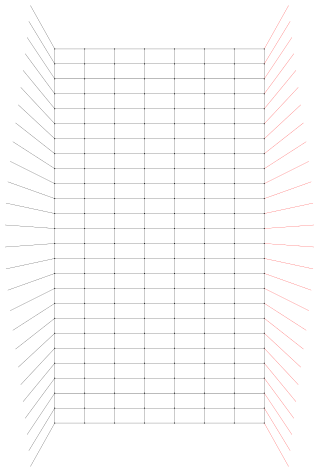

In [18]:
dem.diagram("matchgraph-svg")

<!-- In the diagram above, each node is a detector and each edge is an error mechanism. The matcher is going to decode errors by trying to match each excited node to another nearby excited node, or to the side boundaries, which minimizes the number of edges that were used.

The detector error model format is easier for decoders to consume than a raw circuit, because everything is explained in terms of observable symptoms and hidden symptoms, which is how decoders usually conceptualize the problem space.
For example, some decoders can be configured using a weighted graph, and [`stim.DetectorErrorModel`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.DetectorErrorModel) is effectively just a weighted graph.
It might be a pain to write the glue code that converts the [`stim.DetectorErrorModel`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.DetectorErrorModel) into exactly the right kind of graph expected by the decoder, but it's much easier than starting from the circuit or generating the graph from scratch – and you only have to write that code once instead of once per circuit.

For this tutorial, you'll use existing packages instead of writing your own glue code.
Specifically, you'll use the open-source package [PyMatching](https://github.com/oscarhiggott/PyMatching) as your decoder.
PyMatching is a minimum-weight perfect matching decoder written by Oscar Higgott.
You can install it using `pip install pymatching`: -->

上の図では、各ノードが検出器であり、各エッジがエラー・メカニズムで、デコーダはマッチングさせて復号しようとしています。

このチュートリアルでは、独自のグルー・コードを書く代わりに、既存のパッケージを使います。
具体的には、オープンソースのパッケージ[PyMatching](https://github.com/oscarhiggott/PyMatching)をデコーダとして使います。
PyMatchingはOscar Higgottによって書かれた最小重み完全マッチングアルゴリズムを使ったデコーダです。
pip install pymatching`でインストールできます：

In [19]:
!pip install pymatching~=2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 649.5/649.5 kB 14.5 MB/s eta 0:00:00


In [20]:
import pymatching

<!-- Now you're going to write a method that will sample a circuit using Stim, decode it using PyMatching, and count how often it gets the right answer.

First, you sample detection events and observable flips from the circuit.
You do this by creating a sampler with [`circuit.compile_detector_sampler()`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.compile_detector_sampler) and then calling [`sampler.sample(shots, separate_observables=True)`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.CompiledDetectorSampler.sample).
The `separate_observables=True` argument is saying that you want the result of the method to be a tuple where the first entry is detection event data to give to the decoder and the second entry is the observable flip data the decoder is supposed to predict.

Second, you extract decoder information by using [`stim.Circuit.detector_error_model(...)`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.detector_error_model) and create a decoder from this information using [`pymatching.Matching.from_detector_error_model`](https://pymatching.readthedocs.io/en/latest/api.html#pymatching.matching.Matching.from_detector_error_model).

Third, you run `matching.predict` to get the predicted observable flips.

Fourth, you compare the predictions made by PyMatching to the actual observable flip data that was sampled.
Anytime the prediction differs, it indicates a logical error. -->

では、Stimを使って回路をサンプリングし、PyMatchingを使ってデコードし、正しい答えが得られる頻度をカウントするメソッドを書きます。

まず、回路から検出イベントと観測可能なフリップをサンプリングします。
これは、[`circuit.compile_detector_sampler()`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.compile_detector_sampler)でサンプラーを作成し、[`sampler.sample(shots, separate_observables=True)`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.CompiledDetectorSampler.sample)を呼び出すことで行います。
separate_observables=True`の引数は、メソッドの結果をタプルにすることを意味しています。最初のエントリはデコーダに渡す検出イベントデータで、2番目のエントリはデコーダが予測する観測フリップデータです。

次に、[`stim.Circuit.detector_error_model(...)`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.Circuit.detector_error_model)を使用してデコーダ情報を抽出し、[`pymatching.Matching.from_detector_error_model`](https://pymatching.readthedocs.io/en/latest/api.html#pymatching.matching.Matching.from_detector_error_model)を使用してこの情報からデコーダを作成します。

第三に、`matching.predict`を実行して、予測された観測可能なフリップを得る。

4つ目は、PyMatchingによる予測と実際にサンプリングされた観測可能フリップデータを比較します。
予測値が異なる場合はいつでも論理エラーを示します。

In [21]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

<!-- You can try this method on the repetition code circuit: -->
この方法を繰り返し符号の回路で試すことができます。

In [22]:
circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 6 wrong predictions (logical errors) out of 100000 shots


You can check that increasing the physical noise strength increases the logical error rate.
Try increasing the between-round depolarization strength to 13%:

物理ノイズの強度を上げると、論理エラー率が増加することを確認できます。
ラウンド間の脱分極強度を13%に増やしてみてください：

In [23]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.13,
    before_measure_flip_probability=0.01)
num_shots = 10_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 1266 wrong predictions (logical errors) out of 10000 shots


<!-- As you can see, you get a lot more wrong predictions with this higher noise strength. -->

ご覧のように、ノイズ強度が高いほど、間違った予測が多くなります。

<a class="anchor" id="rep-code"></a>
# 7. Estimate the threshold of a repetition code using Monte Carlo sampling

Estimating the threshold of an error correcting code really just comes down to trying a bunch of physical error rates and code distances.
You plot out the logical error rate vs physical error rate curve for each distance, and see where the curves cross.
That's where the physical error rate gets bad enough that increasing the distance starts to make the logical error rate worse, instead of better.
That's the threshold physical error rate.

You can estimate the threshold of the repetition code, for the specific type of noise you're using, by plotting the logical error rate at various code distances and physical error rates:

<a class="anchor" id="rep-code"></a>.
# モンテカルロ・サンプリングを使って繰り返しコードの閾値を推定する

誤り訂正符号のしきい値を推定するために必要なのは、物理的な誤り率と符号の距離をたくさん試すことだけです。
各符号距離について論理誤り率対物理誤り率の曲線をプロットし、曲線がどこで交差するかを見ることで閾値がわかります。
物理誤り率が十分に悪化し、距離を長くすると論理エラー率が良くなるどころか悪化し始める点、それが物理エラー率のしきい値です。

様々な符号距離と物理誤り率における論理エラーレートをプロットすることで、使用している特定のタイプのノイズに対する繰り返し符号の閾値を推定することができます：

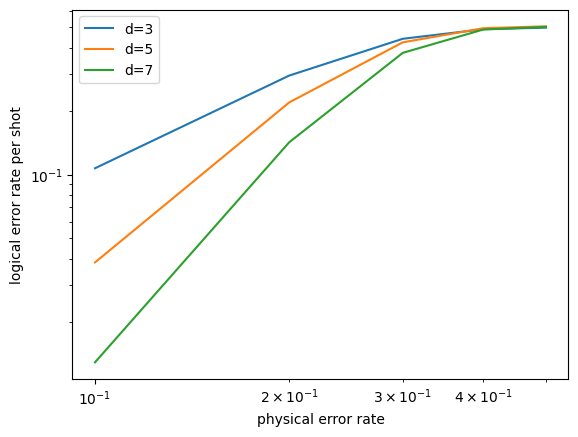

In [24]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

<!-- From the results here you can see that the repetition code has amazingly good performance! Well... it's not *quite* so amazing when you remember that you're using a phenomenological noise model (instead of a circuit-level noise model) and also that you're inserting depolarizing errors instead of bit-flip errors (the repetition code is immune to Z errors, and when a depolarizing error occurs it's a Z error one third of the time).

Still, you can see that it's not so hard to run a few different cases and plot them out. A bit tedious, maybe. -->

この結果から、反復コードが驚くほど優れたパフォーマンスを持っていることがわかります！ただ、（回路レベルのノイズモデルではなく）現象論的ノイズモデルを使用していること、またビット反転エラーの代わりに脱分極エラーを挿入していること（繰り返し符号はZエラーに耐性があり、脱分極エラーが発生すると3分の1の確率でZエラーになるだけである）を思い出すと、それほど驚くべきことではありません。

いずれにせよ、いくつかの異なるケースを実行し、それをプロットすることが簡単にできました。

<!-- <a class="anchor" id="use-sinter"></a>
# 8. Use `sinter` to streamline the Monte Carlo sampling process

Now that you understand the basic workflow of sampling from a circuit, making a decoder predict the observable flips, and plotting out the result, you probably never want to do that by hand ever again. And that's without even getting into dividing work into batches, or across multiple CPU cores!

Fortunately, you can use [Sinter](https://pypi.org/project/sinter/) to do almost the entire thing for you. Install Sinter using `pip install sinter`: -->

<!-- <a class="anchor" id="use-sinter"></a>. -->
# sinter`を使ってモンテカルロ・サンプリング処理を効率化する
[Sinter](https://pypi.org/project/sinter/) を使えば、作業をバッチに分けたり、複数のCPUコアに分割したりといったことをやってくれます。pip install sinter`を使ってSinterをインストールしてください：

In [25]:
!pip install sinter~=1.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 kB 6.6 MB/s eta 0:00:00


In [26]:
import sinter
from typing import List

<!-- Wrap your circuits into [`sinter.Task`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.Task) instances, and give those tasks to [`sinter.collect`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.collect).
Sinter will spin up multiple worker processes to sample from and decode these circuits.
[`sinter.collect`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.collect) takes a variety of useful options, such as the maximum number of shots or errors to take from each task, as well as the number of workers to use: -->

回路を[`sinter.Task`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.Task)インスタンスにラップし、それらのタスクを[`sinter.collect`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.collect)に渡します。
Sinterは複数のワーカープロセスをスピンアップして、これらの回路からサンプリングしてデコードします。
[`sinter.collect`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.collect)は、使用するワーカーの数だけでなく、各タスクから取得するショット数やエラーの最大数など、様々な便利なオプションを取ります：

In [27]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

<!-- Sinter also has a [`sinter.plot_error_rate`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.plot_error_rate) method which can be used to plot the logical error rates. This method automatically adds highlighted regions quantifying uncertainty in the estimates. -->

Sinterには[`sinter.plot_error_rate`](https://github.com/quantumlib/Stim/blob/main/doc/sinter_api.md#sinter.plot_error_rate)メソッドもあり、論理誤り率をプロットするために使用することができます。このメソッドは、推定値の信頼区間を示すハイライト領域を自動的に追加します。

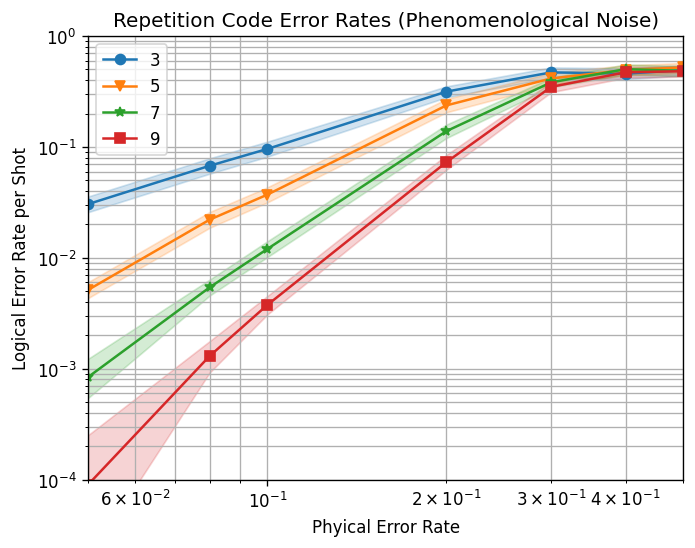

In [28]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

<!-- `sinter`'s goal is to make getting these kinds of results fast and easy. -->
sinter`の目標は、この種の結果を素早く簡単に得られるようにすることです。

## 演習：量子誤り訂正符号の閾値の数値計算
𝑛量子ビット繰り返し符号[[𝑛,1,𝑛]]の物理誤り率に対する論理誤り率がどうなるかをプロットしなさい。
- 上の例以外の任意のノイズを試すこと。
- 符号化-物理誤り-シンドローム測定-復号-訂正-論理誤りの確認の順でシミュレートされる。
- まず異なる符号長(𝑛=3,5,7,9…) でプロットする。
- 誤り閾値(符号長を変えた複数の曲線の交点)を導出すること。この際、交点が見られない場合は物理誤り率を変えて交点を探すこと。
- 信頼区間もプロットすること。

# Additional resources
## Getting help

- You can ask questions about quantum circuits, Stim, error correction, and related topics on the [Quantum Computing Stack Exchange](https://quantumcomputing.stackexchange.com/).
Use the tag `stim`.

## Stim reference material

- [Stim Python API Reference](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md)
- [Stim Supported Gates Reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md)
- [Stim Command Line Reference](https://github.com/quantumlib/Stim/blob/main/doc/usage_command_line.md)
- [Stim Circuit File Format (.stim)](https://github.com/quantumlib/Stim/blob/main/doc/file_format_stim_circuit.md)
- [Stim Detector Error model Format (.dem)](https://github.com/quantumlib/Stim/blob/main/doc/file_format_dem_detector_error_model.md)
- [Stim Results Format Reference](https://github.com/quantumlib/Stim/blob/main/doc/result_formats.md)

## Talks and videos

- ["Software and the Honeycomb Code"](https://www.youtube.com/watch?v=O3NaTGmY0Rw) by Craig Gidney at the weekly Duke/Pratt quantum computing seminar
- ["Estimating overheads for quantum fault-tolerance in the honeycomb code"](https://www.youtube.com/watch?v=ND9OoqJ0NMw) by Mike Newman at the [APS March Meeting 2022](https://web.archive.org/web/20240716155117/https://meetings.aps.org/Meeting/MAR22/Content/4178)
- ["(Demo/Tutorial) Estimating the threshold of a new quantum code using Stim and PyMatching"](https://www.youtube.com/watch?v=E9yj0o1LGII) by Craig Gidney
- ["Relaxing Hardware Requirements for Surface Code Circuits using Time Dynamics"](https://www.youtube.com/watch?v=FuP1exdZJkg) by Matt McEwen at [QEC 2023](https://web.archive.org/web/20241013042627/https://quantum.sydney.edu.au/qec23)

## Papers with Stim circuits

- A list of papers known to have included downloadable Stim circuits is available from the [doc/circuit_data_references.md](circuit_data_references.md) file in the [Stim repository on GitHub](https://github.com/quantumlib/stim).

## Learning Python

- [Google's Python class](https://developers.google.com/edu/python)
- [Google's Crash Course on Python](https://www.coursera.org/learn/python-crash-course) at Coursera
- University of Michigan's [Python for Everybody](https://www.coursera.org/specializations/python) at Coursera
- Python.org's [Python Tutorial](https://docs.python.org/3/tutorial/)

## Learning quantum computing


- [Quantum computing for the very curious](https://quantum.country/qcvc) by Andy Matuschak and Michael Nielsen
- [Building Google's quantum computer]() by Marissa Giustina (2018)
- MIT's [Quantum Information Science I](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+8.370.1x+1T2018/about)
- John Preskill's [Ph/CS 219A Quantum Computation](https://www.youtube.com/playlist?list=PL0ojjrEqIyPy-1RRD8cTD_lF1hflo89Iu) on YouTube
- Quantum AI's YouTube content:
  - [Quantum Programming with Cirq](https://www.youtube.com/playlist?list=PLpO2pyKisOjLVt_tDJ2K6ZTapZtHXPLB4)
  - [QuantumCasts](https://www.youtube.com/playlist?list=PLQY2H8rRoyvwcpm6Nf-fL4sIYQUXtq3HR)
- [Quantum computing for the determined](https://michaelnielsen.org/blog/quantum-computing-for-the-determined/) by Michael Nielsen
- Michael Nielsen and Isaac Chuang's [Quantum Computation And Quantum Information](https://archive.org/embed/QuantumComputationAndQuantumInformation10thAnniversaryEdition)


## Learning quantum error correction

- Quantum AI's [quantum computing journey](https://quantumai.google/learn/map)
- Coursera course [Hands-on quantum error correction with Google Quantum AI](https://www.coursera.org/learn/quantum-error-correction) by Austin Fowler

<img style="float:right" width="65px" align="right" src="https://raw.githubusercontent.com/quantumlib/Stim/refs/heads/main/doc/logo_128x128.svg">

今回の資料は[Stim tutorial](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb)をもとに作成した。